In [30]:
import gc
import sys
from time import time

import kernelforge
import matplotlib.pyplot as plt
import numpy as np
import rdkit
import scipy
from kernelforge import (
    _kernels,
    inverse_distance_upper,
    inverse_distance_upper_and_jacobian,
    kernel_asymm,
    kernel_symm,
)
from kernelforge._kernels import rbf_hessian_full_tiled_gemm, solve_cholesky
from rdkit import Chem
from rdkit.Chem import rdFMCS, rdmolops
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

In [10]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")


In [11]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
y = train["E"].flatten()
offset = y.mean()
y -= offset

In [85]:
perms_S3 = [
(0, 1, 2, 3, 4, 5, 6, 7, 8),
(0, 1, 2, 3, 4, 5, 7, 6, 8),
(0, 1, 2, 3, 4, 6, 5, 7, 8),
(0, 1, 2, 3, 4, 6, 7, 5, 8),
(0, 1, 2, 3, 4, 7, 5, 6, 8),
(0, 1, 2, 3, 4, 7, 6, 5, 8),
(0, 1, 2, 4, 3, 5, 6, 7, 8),
(0, 1, 2, 4, 3, 5, 7, 6, 8),
(0, 1, 2, 4, 3, 6, 5, 7, 8),
(0, 1, 2, 4, 3, 6, 7, 5, 8),
(0, 1, 2, 4, 3, 7, 5, 6, 8),
(0, 1, 2, 4, 3, 7, 6, 5, 8),
]
perms_S3 = np.asarray(perms_S3)
perms_S3 = perms_S3[:1]
perms_S3

array([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [86]:
def build_tril_perms_lin(tril_perms):
    """
    tril_perms: (P,D)
    returns: tril_perms_lin (P*D,) suitable for np.tile(...)[tril_perms_lin]
    """
    P, D = tril_perms.shape
    perm_offsets = np.arange(P)[:, None] * D
    tril_perms_lin = (tril_perms + perm_offsets).ravel(order="F")
    return tril_perms_lin

In [87]:
def build_tril_perms(perms):
    """
    perms: (P,N) atom permutations
    returns: tril_perms (P,D) index permutations in lower-tri order
    """
    perms = np.asarray(perms, int)
    P, N = perms.shape
    i, j = np.tril_indices(N, k=-1)
    pairs = np.stack((i, j), axis=1)
    pair_to_idx = {tuple(p): k for k,p in enumerate(pairs)}

    D = pairs.shape[0]
    tril_perms = np.empty((P, D), int)
    for pidx, perm in enumerate(perms):
        for k, (a, b) in enumerate(pairs):
            aa, bb = perm[a], perm[b]
            if aa > bb:
                key = (aa, bb)
            else:
                key = (bb, aa)
            tril_perms[pidx, k] = pair_to_idx[key]
    return tril_perms


In [88]:
def descriptor_packed_jacobian(R):
    """
    R: (N,3) coordinates
    Returns:
      phi: (D,) inverse distances (i>j, lower-tri order)
      r_d_desc: (D,3) packed Jacobian components
      pairs: (D,2) index pairs (i>j)
    """
    R = np.asarray(R, float)
    N = R.shape[0]

    # lower-triangular atom pairs
    i, j = np.tril_indices(N, k=-1)
    pairs = np.stack((i, j), axis=1)     # (D,2)
    D = pairs.shape[0]

    # pair differences and distances
    pdiff = R[i] - R[j]                  # (D,3)
    r = np.linalg.norm(pdiff, axis=1)    # (D,)
    if np.any(r == 0.0):
        raise ValueError("Zero interatomic distance encountered.")

    # descriptor and packed Jacobian
    phi = 1.0 / r                        # (D,)
    r_d_desc = pdiff / (r**3)[:, None]   # (D,3)

    return phi, r_d_desc, pairs

In [89]:
def expand_full_jacobian(r_d_desc, pairs, N):
    """Expand packed (D,3) to full (D,3N)."""
    D = r_d_desc.shape[0]
    J = np.zeros((D, 3*N), dtype=r_d_desc.dtype)
    for k,(i,j) in enumerate(pairs):
        g = r_d_desc[k]
        J[k, 3*i:3*i+3] -= g
        J[k, 3*j:3*j+3] += g
    return J

In [90]:
# --------- low-level helper (row-by-row accumulation) ---------
def accum_row_outer(H, ai, bi, aj, bj, gi, gj, coeff):
    """
    Add coeff * outer(gi, gj) into H blocks corresponding to atom pairs (ai,bi) x (aj,bj).
    gi, gj are (3,) packed row vectors.
    """
    for u in range(3):
        for v in range(3):
            H[3*ai+u, 3*aj+v] += coeff * gi[u] * gj[v]
            H[3*ai+u, 3*bj+v] -= coeff * gi[u] * gj[v]
            H[3*bi+u, 3*aj+v] -= coeff * gi[u] * gj[v]
            H[3*bi+u, 3*bj+v] += coeff * gi[u] * gj[v]

# --------- packed JT_v -----------
def JT_v_packed(r_d_desc, pairs, v, N):
    """
    v: (D,) in descriptor space
    r_d_desc: (D,3), pairs: (D,2)
    Returns Cartesian projection: (3N,)
    """
    out = np.zeros(3*N, dtype=float)
    for k,(i,j) in enumerate(pairs):
        g = r_d_desc[k]   # (3,)
        w = v[k]
        out[3*i:3*i+3] -= w * g
        out[3*j:3*j+3] += w * g
    return out

# --------- single block, selectable kernel ---------
def hessian_block_packed(phi_i, rdi, phi_j, rdj, pairs, tril_perms,
                         sigma, kernel="matern52", perm_norm="mean"):
    """
    Hessian block H_ij (3N x 3N) using packed Jacobians.
    kernel: "gaussian" or "matern52"
    """
    D = phi_i.size
    N = int(np.max(pairs) + 1)
    P = tril_perms.shape[0]
    norm = (1.0 / P) if perm_norm == "mean" else 1.0

    H = np.zeros((3*N, 3*N), dtype=float)

    sqrt5 = np.sqrt(5.0)

    for p in range(P):
        idx = tril_perms[p]
        phi_jp  = phi_j[idx]
        rdj_p   = rdj[idx]
        pairs_p = pairs[idx]

        d = phi_i - phi_jp
        r2 = np.dot(d,d)
        r  = np.sqrt(r2)

        if kernel == "gaussian":
            # Gaussian kernel derivatives
            e = np.exp(-0.5*r2/sigma**2)
            a = e / sigma**4
            b = e / sigma**2

        elif kernel == "matern52":
            if r == 0.0:
                e = 1.0
                rho = 0.0
            else:
                rho = sqrt5 * r / sigma
                e   = np.exp(-rho)
            a = (25.0/(3.0*sigma**4)) * e
            b = ( 5.0/(3.0*sigma**2)) * (1.0 + rho) * e

        else:
            raise ValueError("Unknown kernel: %s" % kernel)

        # Term A
        delta_cart = JT_v_packed(rdj_p, pairs_p, d, N)
        s_i_cart   = JT_v_packed(rdi,   pairs,   a*d, N)
        H += norm * np.outer(s_i_cart, delta_cart)

        # Term B
        coeff = - norm * b
        for k in range(D):
            ai, bi = pairs[k]
            aj, bj = pairs_p[k]
            gi = rdi[k]
            gj = rdj_p[k]
            accum_row_outer(H, ai, bi, aj, bj, gi, gj, coeff)

    return H

# --------- full symmetric kernel assembly ---------
def assemble_training_kernel_packed(PHI, RD, pairs, tril_perms,
                                    sigma, kernel="matern52", perm_norm="sum"):
    """
    Build full symmetric training kernel K using packed Jacobians.
    kernel: "gaussian" or "matern52"
    """
    M, D = PHI.shape
    N = int(np.max(pairs) + 1)
    dim = 3 * N

    K = np.zeros((M*dim, M*dim), dtype=float)
    for j in tqdm(range(M)):
        for i in range(j, M):
            Hij = hessian_block_packed(PHI[i], RD[i], PHI[j], RD[j],
                                       pairs, tril_perms, sigma,
                                       kernel=kernel, perm_norm=perm_norm)
            i0, i1 = i*dim, (i+1)*dim
            j0, j1 = j*dim, (j+1)*dim
            K[i0:i1, j0:j1] = Hij
            if i != j:
                K[j0:j1, i0:i1] = Hij.T
    return K



In [91]:
X = np.asarray([descriptor_packed_jacobian(r)[0] for r in train["R"]])
dX = np.asarray([descriptor_packed_jacobian(r)[1] for r in train["R"]])
pairs = descriptor_packed_jacobian(train["R"][0])[2]

In [92]:
Xp = np.asarray([descriptor_packed_jacobian(r)[0] for r in test["R"]])
dXp = np.asarray([descriptor_packed_jacobian(r)[1] for r in test["R"]])

In [93]:
tril_perms = build_tril_perms(perms_S3)
tril_perms_lin = build_tril_perms_lin(tril_perms)

In [143]:
np.set_printoptions(threshold=np.inf, linewidth=999)
sigma = 1.0
n_train = 10
K = assemble_training_kernel_packed(X[:n_train], dX[:n_train], pairs, tril_perms, sigma, kernel="gaussian")
K[:27, :12]

  0%|          | 0/10 [00:00<?, ?it/s]

array([[-4.03058652e-01, -2.03012168e-02,  3.84583892e-02,  1.29721550e-01,  8.72441083e-02,  2.98628422e-03,  1.50431467e-01, -1.24959212e-01,  6.81662811e-03,  1.94138054e-03,  2.34542813e-02, -2.85266170e-02],
       [-2.03012168e-02, -7.57098919e-01,  1.05959980e-02,  8.72441083e-02,  5.86759442e-02,  2.00842269e-03, -1.24959212e-01,  1.03800122e-01, -5.66238231e-03,  2.34542813e-02,  2.83356765e-01, -3.44636863e-01],
       [ 3.84583892e-02,  1.05959980e-02, -9.06914687e-01,  2.98628422e-03,  2.00842269e-03,  6.87464298e-05,  6.81662811e-03, -5.66238231e-03,  3.08887627e-04, -2.85266170e-02, -3.44636863e-01,  4.19169690e-01],
       [ 1.29721550e-01,  8.72441083e-02,  2.98628422e-03, -9.04098650e-01,  3.12043830e-01,  4.98456682e-02,  3.31095168e-02, -7.38103281e-04,  1.10338763e-03,  1.60401309e-02,  1.87529493e-02, -9.90567718e-03],
       [ 8.72441083e-02,  5.86759442e-02,  2.00842269e-03,  3.12043830e-01, -6.74780959e-01,  5.12402231e-02, -7.38103281e-04,  1.64543765e-05, -2.4

In [145]:
np.save("K_gdml.npy", K)

In [146]:
K_solve = -K.copy()
yf = -train["F"][:n_train].flatten()
y_std = np.std(yf)
yf /= y_std
# print(yf)
K_solve[np.diag_indices_from(K_solve)] += 1e-10
# Cholesky (do not overwrite K in case we need to retry)
L, lower = scipy.linalg.cho_factor(
    K_solve, overwrite_a=False, check_finite=False
)
alphas = -scipy.linalg.cho_solve(
    (L, lower), yf, overwrite_b=False, check_finite=False
)
print("DID CHOLESKY")
# alpha = np.linalg.solve(K_solve, yf)
alpha = solve_cholesky(K_solve, yf)
print(alphas[:54])
alpha[:54]

DID CHOLESKY
[ -125.78978721  -115.34656493  -230.33926601    10.02919851  -462.33458351    31.14782605  -119.26384287  -526.56817423   135.17156723  -368.28349429   -31.00374264   -62.28321626   374.76334507  -174.4968223   -111.16864128   530.18434247   649.64299448   -85.13692679   126.25347524   -96.93969854   -80.90413945   130.66212215    61.56321817    89.93105475  -512.61048956   695.48181807   359.53401428   -31.54934019    39.75928928   229.47410181    -8.17300101   -95.37547925    20.69063151   317.53856525  -500.91576523 -1110.53315255  -104.20418966   614.09976433   707.09757045    42.38435864  -251.07460033   591.74965525  -507.48004012   -97.25059923 -1269.11801612   -28.50737101  -797.90404071  1192.22414561   763.75336599   718.74658765   160.96070293  -535.66238681   415.86277672  -522.55298332]


array([  125.78998255,   115.346699  ,   230.33952077,   -10.02874582,   462.33433706,   -31.14763337,   119.26429833,   526.5686395 ,  -135.17098149,   368.28362128,    31.00375014,    62.28336231,  -374.76348567,   174.49710775,   111.16878713,  -530.18401792,  -649.64353348,    85.13688526,  -126.25266101,    96.93942602,    80.90452461,  -130.66168032,   -61.56328384,   -89.93076884,   512.61095598,  -695.48122375,  -359.53335129,    31.54835697,   -39.76028226,  -229.47502266,     8.17282249,    95.37579733,   -20.6919604 ,  -317.53869063,   500.91363208,  1110.53264079,   104.20225486,  -614.10115803,  -707.09839116,   -42.38571672,   251.07376492,  -591.75064156,   507.479349  ,    97.25178433,  1269.116381  ,    28.50798   ,   797.90429108, -1192.22542456,  -763.75279819,  -718.74597376,  -160.96210422,   535.66304091,  -415.86479485,   522.55246046])

In [109]:
def pack_alphas(PHI, RD, pairs, alphas):
    """
    Contract alphas (Cartesian) into descriptor space.
    
    Parameters
    ----------
    PHI    : (M,D) descriptor array (not used, just to get sizes)
    RD     : (M,D,3) packed Jacobians for each sample
    pairs  : (D,2) atom index pairs
    alphas : (M*3N,) regression weights in Cartesian space
    
    Returns
    -------
    RD_ALPHA : (M,D) each row is J_m @ alpha_m
    """
    M, D, _ = RD.shape
    N = int(np.max(pairs) + 1)
    dim = 3 * N
    alphas = alphas.reshape(M, dim)

    RD_ALPHA = np.zeros((M, D))
    for m in range(M):
        v = np.zeros(D)
        for k, (i, j) in enumerate(pairs):
            g = RD[m, k]        # (3,)
            # contribution from atoms i,j
            v[k] = (-g @ alphas[m, 3*i:3*i+3]) + (g @ alphas[m, 3*j:3*j+3])
        RD_ALPHA[m] = v
    return RD_ALPHA

In [110]:
# --- packed projection: J^T @ v (v in descriptor space) ---
def JT_v_packed(r_d_desc, pairs, v, N):
    out = np.zeros(3*N, dtype=float)
    for k,(i,j) in enumerate(pairs):
        g = r_d_desc[k]  # (3,)
        w = v[k]
        out[3*i:3*i+3] -= w * g
        out[3*j:3*j+3] += w * g
    return out


def predict_kernel_packed_simple(
    phi_q, rd_q, pairs,                # query: (D,), (D,3), (D,2)
    PHI, RD_ALPHA,                     # training banks: (M,D), (M,D) with RD_ALPHA[m] = J_m @ alpha_m
    tril_perms,                        # (P,D) descriptor row permutations (from atom perms)
    sigma, kernel="matern52",          # "gaussian" or "matern52"
    std=1.0, c=0.0,                    # model scale & energy offset
    return_energy=True
):
    """
    Returns (E, F) or (F,) for the query geometry.

    phi_q   : (D,)      query descriptor
    rd_q    : (D,3)     query packed Jacobian
    pairs   : (D,2)     atom index pairs (i>j)
    PHI     : (M,D)     training descriptors
    RD_ALPHA: (M,D)     prepacked (J_m @ alpha_m) per training sample
    tril_perms : (P,D)  descriptor row permutations
    sigma   : kernel length scale
    kernel  : "gaussian" or "matern52"
    """
    phi_q   = np.asarray(phi_q,   float)
    rd_q    = np.asarray(rd_q,    float)
    PHI     = np.asarray(PHI,     float)
    RD_ALPHA= np.asarray(RD_ALPHA,float)
    tril    = np.asarray(tril_perms, int)

    D = phi_q.size
    N = int(np.max(pairs) + 1)
    sqrt5 = np.sqrt(5.0)

    # descriptor-space accumulator and energy (pre-scale)
    F_desc = np.zeros(D, dtype=float)
    E_pred = 0.0

    sig_inv = 1.0 / sigma
    if kernel == "matern52":
        mat52_base_fact = 5.0 / (3.0 * sigma**3)
        diag_scale_fact = 5.0 / sigma

    for j in range(PHI.shape[0]):
        phi_j_perm  = PHI[j][tril]       # (P,D)
        rda_j_perm  = RD_ALPHA[j][tril]  # (P,D)

        diff = phi_q[None, :] - phi_j_perm  # (P,D)

        if kernel == "gaussian":
            # squared distances per perm
            r2 = np.sum(diff**2, axis=1)       # (P,)
            base = np.exp(-0.5 * r2 / sigma**2)
            a = base / sigma**4
            b = base / sigma**2

            a_x2 = np.einsum('pd,pd->p', diff, rda_j_perm)  # (P,)
            # F_desc contributions
            F_desc += (a_x2 * a).dot(diff)                  # (D,)
            F_desc -= b.dot(rda_j_perm)                     # (D,)
            E_pred += a_x2.dot(base)                        # energy-like term

        elif kernel == "matern52":
            norm_ab = sqrt5 * np.linalg.norm(diff, axis=1)   # (P,)
            base = np.exp(-norm_ab * sig_inv) * mat52_base_fact
            a_x2 = np.einsum('pd,pd->p', diff, rda_j_perm)   # (P,)

            # first term
            F_desc += (a_x2 * base).dot(diff) * diag_scale_fact
            # rescale base
            base *= (norm_ab + sigma)
            # second term
            F_desc -= base.dot(rda_j_perm)
            # energy
            E_pred += a_x2.dot(base)

        else:
            raise ValueError(f"Unknown kernel {kernel}")

    # Project to Cartesian: F = J_q^T @ F_desc  (packed)
    F = JT_v_packed(rd_q, pairs, F_desc, N)

    # Final scaling & energy offset
    F *= std
    if return_energy:
        E = E_pred * std + c
        return E, F
    else:
        return (F,)


In [111]:
# --- helper ---
def accum_row_outer(H, ai, bi, aj, bj, gi, gj, coeff):
    """Accumulate coeff * outer(gi, gj) into Cartesian blocks of H."""
    for (I, gI) in [(ai, gi), (bi, -gi)]:
        for (J, gJ) in [(aj, gj), (bj, -gj)]:
            H[3*I:3*I+3, 3*J:3*J+3] += coeff * np.outer(gI, gJ)

def predict_kernel_block_packed(
    phi_q, rd_q, pairs,             # query descriptor (D,), Jacobian (D,3), pairs (D,2)
    PHI, RD,                        # training banks: (M,D), (M,D,3)
    tril_perms,                     # (P,D) descriptor row permutations
    sigma, kernel="matern52"
):
    """
    Construct the kernel block between query and all training samples.

    Returns:
      Kq : (3N, M*3N)   force-force kernel block (not yet multiplied by alphas)

    phi_q   : (D,)
    rd_q    : (D,3)
    pairs   : (D,2)
    PHI     : (M,D)
    RD      : (M,D,3)
    tril_perms : (P,D)
    sigma   : kernel length scale
    kernel  : "gaussian" or "matern52"
    """
    phi_q   = np.asarray(phi_q, float)
    rd_q    = np.asarray(rd_q,  float)
    PHI     = np.asarray(PHI,   float)
    RD      = np.asarray(RD,    float)
    tril    = np.asarray(tril_perms, int)

    D = phi_q.size
    N = int(np.max(pairs) + 1)
    dim = 3*N
    sqrt5 = np.sqrt(5.0)

    Kq = np.zeros((dim, PHI.shape[0]*dim))

    sig_inv = 1.0 / sigma
    if kernel == "matern52":
        mat52_base_fact = 5.0 / (3.0 * sigma**3)
        diag_scale_fact = 5.0 / sigma

    for j in range(PHI.shape[0]):
        Hj = np.zeros((dim, dim))
        phi_j = PHI[j]
        rdj   = RD[j]

        for p in range(tril.shape[0]):
            idx = tril[p]
            phi_jp = phi_j[idx]
            rdj_p  = rdj[idx]
            pairs_p= pairs[idx]

            diff = phi_q - phi_jp

            if kernel == "gaussian":
                r2 = np.dot(diff, diff)
                base = np.exp(-0.5 * r2 / sigma**2)
                a = base / sigma**4
                b = base / sigma**2
                # Term A: outer(J_q^T (a d), J_j^T d)
                vj = JT_v_packed(rdj_p, pairs_p, diff, N)
                vi = JT_v_packed(rd_q, pairs, a*diff, N)
                Hj += np.outer(vi, vj)
                # Term B: -b * sum_k outer(J_q_row_k, J_j_row_k^p)
                for k in range(D):
                    ai, bi = pairs[k]
                    aj, bj = pairs_p[k]
                    gi = rd_q[k]
                    gj = rdj_p[k]
                    accum_row_outer(Hj, ai, bi, aj, bj, gi, gj, -b)

            elif kernel == "matern52":
                r = np.linalg.norm(diff)
                rho = sqrt5 * r * sig_inv
                e   = np.exp(-rho)
                a = (25.0 / (3.0 * sigma**4)) * e
                b = (5.0 / (3.0 * sigma**2)) * (1+rho) * e
                # Term A
                vj = JT_v_packed(rdj_p, pairs_p, diff, N)
                vi = JT_v_packed(rd_q,  pairs, a*diff, N)
                Hj += np.outer(vi, vj)
                # Term B
                for k in range(D):
                    ai, bi = pairs[k]
                    aj, bj = pairs_p[k]
                    gi = rd_q[k]
                    gj = rdj_p[k]
                    accum_row_outer(Hj, ai, bi, aj, bj, gi, gj, -b)

        # Insert Hj into Kq
        j0, j1 = j*dim, (j+1)*dim
        Kq[:, j0:j1] = Hj

    return Kq



In [136]:
pd_alphas = pack_alphas(X[:n_train], dX[:n_train], pairs, alphas)
idx_test = 0
fp = predict_kernel_packed_simple(
    Xp[idx_test], dXp[idx_test], pairs,            # query: (D,), (D,3), (D,2)
    X[:n_train], pd_alphas,                 # training: (M,D), (M,D) where RD_ALPHA[m] = (J_m @ alpha_m)
    tril_perms,                    # (P,D) descriptor row permutations
    sigma,                         # scalar
    kernel="gaussian",
    return_energy=True
)[1] * y_std
fp

array([-41.19176608,  -0.32436201, -23.22942561, -18.40363706,  11.02112527,  21.81045627,  13.6088945 ,   5.53227021,  17.30133714,  11.35173829,   8.40389081,  13.01584554,  16.49699238, -10.44710141, -21.78945421,  20.60539041, -29.58008605,  15.93733555, -32.47267175,  12.8517    ,  -6.38132113,  17.83370386,  15.32507598,  -7.26136608,  12.17135544, -12.78251281,  -9.40340746])

In [139]:
K_block = predict_kernel_block_packed(
    Xp[idx_test], dXp[idx_test], pairs,             # query descriptor (D,), Jacobian (D,3), pairs (D,2)
    X[:n_train], dX[:n_train],                        # training banks: (M,D), (M,D,3)
    tril_perms,                     # (P,D) descriptor row permutations
    sigma, kernel="gaussian"
) * y_std
K_block[:27,:27]

array([[-9.95192178e+00, -3.73053401e+00, -8.69382193e-01,  3.32445482e+00,  2.22995751e+00,  7.25507511e-02,  3.89717891e+00, -3.22861110e+00,  1.75536594e-01,  1.18585655e-01,  1.42780459e+00, -1.73511994e+00,  3.14766051e-03,  1.89922468e+00,  2.63246725e+00,  5.46162582e-01,  1.02216244e-01,  1.33022274e-02,  5.16412011e-01,  9.35234580e-01,  4.43577124e-01,  6.14633217e-01,  6.80709521e-01, -4.69614216e-01,  9.31346930e-01, -3.16002017e-01, -2.63317595e-01],
       [-6.46894324e-01, -1.82606866e+01,  1.25314309e+00,  2.11567397e+00,  1.39835847e+00,  3.21545344e-02, -2.52406170e+00,  2.13269905e+00, -1.18780198e-01,  6.34222193e-01,  7.64199611e+00, -9.28858534e+00,  1.13963852e-02,  5.88199944e+00,  8.15066716e+00,  8.65664515e-01,  1.71171380e-01,  1.90713259e-02,  4.10448626e-02,  1.07361144e-01,  5.00725037e-02,  5.42919488e-01,  5.88352723e-01, -4.01711903e-01, -1.03996539e+00,  3.38748307e-01,  3.03968827e-01],
       [ 1.04059945e+00, -9.99042539e-01, -2.35431398e+01, -8.37

In [138]:
fp2 = K_block @ alphas
fp2

array([-41.19176608,  -0.32436201, -23.22942561, -18.40363706,  11.02112527,  21.81045627,  13.6088945 ,   5.53227021,  17.30133714,  11.35173829,   8.40389081,  13.01584554,  16.49699238, -10.44710141, -21.78945421,  20.60539041, -29.58008605,  15.93733555, -32.47267175,  12.8517    ,  -6.38132113,  17.83370386,  15.32507598,  -7.26136608,  12.17135544, -12.78251281,  -9.40340746])

In [132]:
fp

array([ 55.31617014,  -4.52202995, -20.60762845,   7.54793006,  66.50392802,   6.22758247,  -8.71830062,  35.03868224,  62.35370722, -41.07748055,   1.68400551, -17.98601356,   1.35083835, -13.6644941 ,   9.85339488, -39.1708816 , -21.8378942 ,  27.24721386,  -2.67673373, -28.24706192,   9.03465617,   7.08712682,   0.64123329, -26.88285727,  20.34133114, -35.59636889, -49.24005532])

In [133]:
ft = -test["F"][idx_test].flatten()
ft

array([ 46.91837923,  -3.73109559,  -5.94115822,   0.61561766,  72.42908142, -11.67441359,   9.22106886,  32.09283234,  75.64856807, -34.57462118,  10.50739625, -21.64424784,  -4.18701497, -26.3018366 ,  -7.9454866 , -30.84474   , -29.022508  ,  31.95702315,  -2.79564777, -22.39369865,   7.6387786 ,   5.07544835,  -2.40971674, -12.61999033,  10.57150982, -31.17045454, -55.41907336])

RMSE = 9.40 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9511626389685304), pvalue=np.float64(2.86262839963102e-14))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

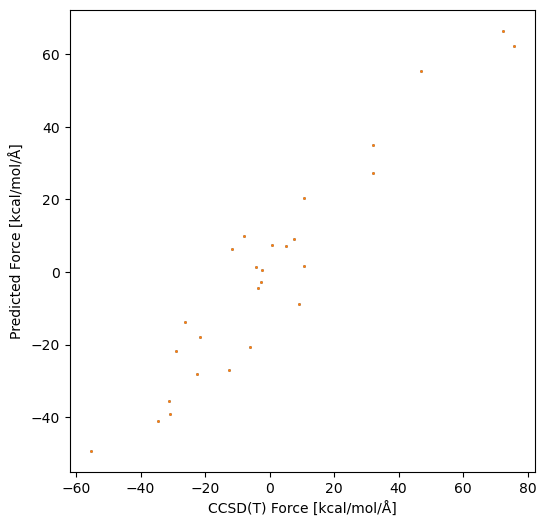

In [135]:
res = pearsonr(ft, fp)
rmse = np.sqrt(np.mean(np.square(ft - fp)))
print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
fig = plt.figure(figsize=(6,6))
plt.scatter(ft, fp, s=1)
plt.scatter(ft, fp2, s=1)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")

In [83]:
Xp[:1]

array([[0.64849932, 0.68062606, 0.39522545, 0.92165687, 0.44166493, 0.48421598, 0.94359693, 0.45625876, 0.52636677, 0.58566549, 0.4690378 , 0.89006228, 0.39324637, 0.32383284, 0.38542212, 0.43412363, 0.88747031, 0.28213909, 0.35725009, 0.37353908, 0.51810628, 0.50123893, 0.90475468, 0.36236913, 0.42892328, 0.34053341, 0.55136473, 0.55608217, 0.50406804, 0.36819288, 1.03719451, 0.42434929, 0.36790047, 0.36663724, 0.26293289, 0.38986984]])